In [1]:
import time
import os

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# This is for the progress bar.
from tqdm.auto import tqdm

from PIL import Image
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFilter

In [2]:
'''
SRM滤波得到图像噪声流
'''
def beforeProcess(path):
 
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (128, 128))
 
    kernal = np.array([[[0,0,0,0,0],[0,-1/4,2/4,-1/4,0],[0,2/4,-4/4,2/4,0],[0,-1/4,2/4,-1/4,0],[0,0,0,0,0]],
                    [[-1/12,2/12,-2/12,2/12,-1/12],[2/12,-6/12,8/12,-6/12,2/12],[-2/12,8/12,-12/12,8/12,-2/12],[2/12,-6/12,8/12,-6/12,2/12],[-1/12,2/12,-2/12,2/12,-1/12]],
                        [[0,0,0,0,0],[0,0,0,0,0],[0,1/2,-2/2,1/2,0],[0,0,0,0,0],[0,0,0,0,0]]])
 
 
    dst_r = (cv2.filter2D(img[:,:,0], -1, kernal[0,:,:]) + cv2.filter2D(img[:,:,1], -1, kernal[0,:,:]) + cv2.filter2D(img[:,:,2], -1, kernal[0,:,:]))/3
    dst_g = (cv2.filter2D(img[:,:,0], -1, kernal[1,:,:]) + cv2.filter2D(img[:,:,1], -1, kernal[1,:,:]) + cv2.filter2D(img[:,:,2], -1, kernal[1,:,:]))/3
    dst_b = (cv2.filter2D(img[:,:,0], -1, kernal[2,:,:]) + cv2.filter2D(img[:,:,1], -1, kernal[2,:,:]) + cv2.filter2D(img[:,:,2], -1, kernal[2,:,:]))/3
    dst = cv2.merge([dst_r, dst_g, dst_b])
    
    '''
    前面dst的数据类型为Double，与cuda上float的数据类型不匹配
    '''
    dst = dst.astype(np.float32)
    
#     print(dst.shape)
#     titles = ['srcImg','convImg']
#     imgs = [img, dst]
 
#     # 画图进行展示
#     for i in range(2):
#         plt.subplot(1,2,i+1)
#         plt.imshow(imgs[i])
#         plt.title(titles[i])
#     plt.show()
    
    return dst

'''
训练集处理
'''
class MyTrainDataset(Dataset):
    
    def __init__(self, input_path):
        self.input_path = input_path
        self.input_class = os.listdir(input_path)
        print(self.input_class)
        self.input_au_root = os.path.join(self.input_path, self.input_class[0])
        self.input_tp_root = os.path.join(self.input_path, self.input_class[1])
        self.input_au = os.listdir(self.input_au_root)
        self.input_tp = os.listdir(self.input_tp_root)
        self.input_files = self.input_au + self.input_tp

        self.input_files.remove('Thumbs.db')
        self.input_files.remove('Thumbs.db')
#         for i, name in enumerate(self.input_files):
#             if name=='Thumbs.db':
#                 print(i)
#                 print(True)

                
        random.shuffle(self.input_files)
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transforms_o = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        if self.input_files[index][:2] == 'Au':
            input_img_path = os.path.join(self.input_au_root, self.input_files[index])
            label = 0
        else:
            input_img_path = os.path.join(self.input_tp_root, self.input_files[index])
            label = 1
        
        input_img = Image.open(input_img_path).convert('RGB')
        noise = beforeProcess(input_img_path)
        input = self.transforms(noise)
        origin = self.transforms_o(input_img)
        
        '''
        验证是否得到噪声信息
        '''
#         print(input_img_path)
#         plt.imshow(noise)
#         plt.show()

        return input, origin, label

'''
验证集处理
'''
class MyValidDataset(Dataset):
    
    def __init__(self, input_path):
        self.input_path = input_path
        self.input_class = os.listdir(input_path)
        print(self.input_class)
        self.input_au_root = os.path.join(self.input_path, self.input_class[4])
        self.input_tp_root = os.path.join(self.input_path, self.input_class[1])
        self.input_au = os.listdir(self.input_au_root)
        self.input_tp = os.listdir(self.input_tp_root)
        self.input_files = self.input_au + self.input_tp
        random.shuffle(self.input_files)
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transforms_o = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        if self.input_files[index][:2] == 'Au':
            input_img_path = os.path.join(self.input_au_root, self.input_files[index])
            label = 0
        else:
            input_img_path = os.path.join(self.input_tp_root, self.input_files[index])
            label = 1
        
        input_img = Image.open(input_img_path).convert('RGB')
        noise = beforeProcess(input_img_path)
        input = self.transforms(noise)
        origin = self.transforms_o(input_img)
        
        '''
        验证是否得到噪声信息
        '''
#         print(input_img_path)
#         plt.imshow(noise)
#         plt.show()

        return input, origin, label
    
    
        
        

In [3]:
'''
超参数
'''
batch_size = 16
n_epochs = 250
patience = 250
learning_rate = 0.0001

In [4]:
'''
数据集路径
'''
train_path = '../input/casia-dataset/CASIA2/'
valid_path = '../input/casia-dataset/CASIA1/'

train_set = MyTrainDataset(train_path)
valid_set = MyValidDataset(valid_path)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, pin_memory=True)


['Au', 'Tp']
['check.py', 'Sp', '01FixSize.py', 'extraction.py', 'Au']


In [5]:
'''
残差卷积网络（引入了BN层以优化随机梯度下降的方法）
'''
class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.relu = nn.ReLU()

    def forward(self, x, y):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 2]
        x = x + y
        '''
        通过卷积层提取图像特征
        '''
        x1 = self.cnn_layer1(x)
        x1 = self.relu(x1)
        x2 = self.cnn_layer2(x1)
        x2 = self.relu(x2+x1)

        x3 = self.cnn_layer3(x2)
        x3 = self.relu(x3)
        x4 = self.cnn_layer4(x3)
        x4 = self.relu(x4+x3)

        x5 = self.cnn_layer5(x4)
        x5 = self.relu(x5)
        x6 = self.cnn_layer6(x5)
        x6 = self.relu(x6+x5)

        xout = x6.flatten(1)

        '''
        特征通过全连接层
        '''
        xout = self.fc_layer(xout)
        return xout

In [6]:
'''
检查GPU数量
'''
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 1 GPUs!


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 001/250 ] loss = 0.72137, acc = 0.55764


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 001/250 ] loss = 0.68798, acc = 0.56719
[ Valid | 001/250 ] loss = 0.68798, acc = 0.56719 -> best
Best model found at epoch 0, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 002/250 ] loss = 0.64381, acc = 0.59329


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 002/250 ] loss = 0.68805, acc = 0.56546
[ Valid | 002/250 ] loss = 0.68805, acc = 0.56546


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 003/250 ] loss = 0.63390, acc = 0.60572


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 003/250 ] loss = 0.68811, acc = 0.58893
[ Valid | 003/250 ] loss = 0.68811, acc = 0.58893 -> best
Best model found at epoch 2, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 004/250 ] loss = 0.62040, acc = 0.62178


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 004/250 ] loss = 0.69204, acc = 0.57382
[ Valid | 004/250 ] loss = 0.69204, acc = 0.57382


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 005/250 ] loss = 0.60639, acc = 0.63012


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 005/250 ] loss = 1.06898, acc = 0.50791
[ Valid | 005/250 ] loss = 1.06898, acc = 0.50791


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 006/250 ] loss = 0.58854, acc = 0.64612


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 006/250 ] loss = 0.94016, acc = 0.53234
[ Valid | 006/250 ] loss = 0.94016, acc = 0.53234


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 007/250 ] loss = 0.56692, acc = 0.66257


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 007/250 ] loss = 0.73535, acc = 0.56231
[ Valid | 007/250 ] loss = 0.73535, acc = 0.56231


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 008/250 ] loss = 0.55179, acc = 0.67071


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 008/250 ] loss = 0.70839, acc = 0.57272
[ Valid | 008/250 ] loss = 0.70839, acc = 0.57272


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 009/250 ] loss = 0.53491, acc = 0.68280


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 009/250 ] loss = 0.78576, acc = 0.57690
[ Valid | 009/250 ] loss = 0.78576, acc = 0.57690


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 010/250 ] loss = 0.51873, acc = 0.68666


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 010/250 ] loss = 0.95229, acc = 0.55742
[ Valid | 010/250 ] loss = 0.95229, acc = 0.55742


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 011/250 ] loss = 0.51095, acc = 0.69909


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 011/250 ] loss = 0.75296, acc = 0.55157
[ Valid | 011/250 ] loss = 0.75296, acc = 0.55157


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 012/250 ] loss = 0.49068, acc = 0.71111


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 012/250 ] loss = 0.73287, acc = 0.57401
[ Valid | 012/250 ] loss = 0.73287, acc = 0.57401


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 013/250 ] loss = 0.48862, acc = 0.71161


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 013/250 ] loss = 1.07440, acc = 0.53916
[ Valid | 013/250 ] loss = 1.07440, acc = 0.53916


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 014/250 ] loss = 0.48326, acc = 0.70986


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 014/250 ] loss = 0.79149, acc = 0.56083
[ Valid | 014/250 ] loss = 0.79149, acc = 0.56083


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 015/250 ] loss = 0.47157, acc = 0.71919


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 015/250 ] loss = 0.73749, acc = 0.55086
[ Valid | 015/250 ] loss = 0.73749, acc = 0.55086


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 016/250 ] loss = 0.47033, acc = 0.71615


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 016/250 ] loss = 1.03226, acc = 0.55665
[ Valid | 016/250 ] loss = 1.03226, acc = 0.55665


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 017/250 ] loss = 0.46744, acc = 0.71860


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 017/250 ] loss = 0.82950, acc = 0.57530
[ Valid | 017/250 ] loss = 0.82950, acc = 0.57530


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 018/250 ] loss = 0.45875, acc = 0.72431


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 018/250 ] loss = 0.83317, acc = 0.54392
[ Valid | 018/250 ] loss = 0.83317, acc = 0.54392


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 019/250 ] loss = 0.45349, acc = 0.72595


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 019/250 ] loss = 0.79037, acc = 0.55697
[ Valid | 019/250 ] loss = 0.79037, acc = 0.55697


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 020/250 ] loss = 0.44975, acc = 0.73226


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 020/250 ] loss = 0.76897, acc = 0.55781
[ Valid | 020/250 ] loss = 0.76897, acc = 0.55781


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 021/250 ] loss = 0.44939, acc = 0.73168


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 021/250 ] loss = 0.75694, acc = 0.54649
[ Valid | 021/250 ] loss = 0.75694, acc = 0.54649


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 022/250 ] loss = 0.44401, acc = 0.73508


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 022/250 ] loss = 0.86027, acc = 0.53999
[ Valid | 022/250 ] loss = 0.86027, acc = 0.53999


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 023/250 ] loss = 0.43788, acc = 0.73640


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 023/250 ] loss = 0.82500, acc = 0.56591
[ Valid | 023/250 ] loss = 0.82500, acc = 0.56591


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 024/250 ] loss = 0.43773, acc = 0.73421


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 024/250 ] loss = 0.86577, acc = 0.58243
[ Valid | 024/250 ] loss = 0.86577, acc = 0.58243


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 025/250 ] loss = 0.43268, acc = 0.74105


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 025/250 ] loss = 0.95711, acc = 0.57202
[ Valid | 025/250 ] loss = 0.95711, acc = 0.57202


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 026/250 ] loss = 0.43242, acc = 0.73770


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 026/250 ] loss = 0.95298, acc = 0.55607
[ Valid | 026/250 ] loss = 0.95298, acc = 0.55607


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 027/250 ] loss = 0.42914, acc = 0.74036


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 027/250 ] loss = 0.68560, acc = 0.57009
[ Valid | 027/250 ] loss = 0.68560, acc = 0.57009


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 028/250 ] loss = 0.42648, acc = 0.73843


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 028/250 ] loss = 0.85482, acc = 0.53684
[ Valid | 028/250 ] loss = 0.85482, acc = 0.53684


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 029/250 ] loss = 0.42699, acc = 0.74329


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 029/250 ] loss = 1.06439, acc = 0.54765
[ Valid | 029/250 ] loss = 1.06439, acc = 0.54765


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 030/250 ] loss = 0.42308, acc = 0.74432


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 030/250 ] loss = 1.67668, acc = 0.55388
[ Valid | 030/250 ] loss = 1.67668, acc = 0.55388


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 031/250 ] loss = 0.42686, acc = 0.74039


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 031/250 ] loss = 0.89022, acc = 0.55909
[ Valid | 031/250 ] loss = 0.89022, acc = 0.55909


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 032/250 ] loss = 0.42160, acc = 0.74258


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 032/250 ] loss = 0.89136, acc = 0.56186
[ Valid | 032/250 ] loss = 0.89136, acc = 0.56186


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 033/250 ] loss = 0.41748, acc = 0.74490


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 033/250 ] loss = 1.08603, acc = 0.57864
[ Valid | 033/250 ] loss = 1.08603, acc = 0.57864


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 034/250 ] loss = 0.42181, acc = 0.74073


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 034/250 ] loss = 0.94160, acc = 0.56449
[ Valid | 034/250 ] loss = 0.94160, acc = 0.56449


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 035/250 ] loss = 0.41263, acc = 0.74976


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 035/250 ] loss = 1.04970, acc = 0.57446
[ Valid | 035/250 ] loss = 1.04970, acc = 0.57446


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 036/250 ] loss = 0.40890, acc = 0.74879


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 036/250 ] loss = 0.83268, acc = 0.58674
[ Valid | 036/250 ] loss = 0.83268, acc = 0.58674


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 037/250 ] loss = 0.41747, acc = 0.74372


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 037/250 ] loss = 0.73159, acc = 0.56372
[ Valid | 037/250 ] loss = 0.73159, acc = 0.56372


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 038/250 ] loss = 0.41372, acc = 0.74794


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 038/250 ] loss = 0.81596, acc = 0.55594
[ Valid | 038/250 ] loss = 0.81596, acc = 0.55594


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 039/250 ] loss = 0.41297, acc = 0.74670


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 039/250 ] loss = 0.93046, acc = 0.56854
[ Valid | 039/250 ] loss = 0.93046, acc = 0.56854


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 040/250 ] loss = 0.40832, acc = 0.74892


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 040/250 ] loss = 0.90911, acc = 0.60063
[ Valid | 040/250 ] loss = 0.90911, acc = 0.60063 -> best
Best model found at epoch 39, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 041/250 ] loss = 0.40642, acc = 0.75507


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 041/250 ] loss = 1.01861, acc = 0.57330
[ Valid | 041/250 ] loss = 1.01861, acc = 0.57330


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 042/250 ] loss = 0.40547, acc = 0.75137


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 042/250 ] loss = 1.11933, acc = 0.57735
[ Valid | 042/250 ] loss = 1.11933, acc = 0.57735


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 043/250 ] loss = 0.40558, acc = 0.75298


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 043/250 ] loss = 1.09423, acc = 0.55941
[ Valid | 043/250 ] loss = 1.09423, acc = 0.55941


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 044/250 ] loss = 0.40104, acc = 0.75327


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 044/250 ] loss = 0.73506, acc = 0.59182
[ Valid | 044/250 ] loss = 0.73506, acc = 0.59182


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 045/250 ] loss = 0.40081, acc = 0.75573


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 045/250 ] loss = 0.82189, acc = 0.58063
[ Valid | 045/250 ] loss = 0.82189, acc = 0.58063


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 046/250 ] loss = 0.40169, acc = 0.75441


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 046/250 ] loss = 0.86598, acc = 0.53164
[ Valid | 046/250 ] loss = 0.86598, acc = 0.53164


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 047/250 ] loss = 0.39301, acc = 0.75811


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 047/250 ] loss = 0.89625, acc = 0.58282
[ Valid | 047/250 ] loss = 0.89625, acc = 0.58282


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 048/250 ] loss = 0.39726, acc = 0.75568


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 048/250 ] loss = 0.87009, acc = 0.57517
[ Valid | 048/250 ] loss = 0.87009, acc = 0.57517


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 049/250 ] loss = 0.39778, acc = 0.75309


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 049/250 ] loss = 1.22988, acc = 0.57517
[ Valid | 049/250 ] loss = 1.22988, acc = 0.57517


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 050/250 ] loss = 0.39338, acc = 0.75882


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 050/250 ] loss = 0.98142, acc = 0.57530
[ Valid | 050/250 ] loss = 0.98142, acc = 0.57530


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 051/250 ] loss = 0.39567, acc = 0.75826


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 051/250 ] loss = 2.44998, acc = 0.54623
[ Valid | 051/250 ] loss = 2.44998, acc = 0.54623


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 052/250 ] loss = 0.39546, acc = 0.75834


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 052/250 ] loss = 0.72649, acc = 0.58520
[ Valid | 052/250 ] loss = 0.72649, acc = 0.58520


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 053/250 ] loss = 0.39315, acc = 0.75953


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 053/250 ] loss = 1.01920, acc = 0.58050
[ Valid | 053/250 ] loss = 1.01920, acc = 0.58050


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 054/250 ] loss = 0.39060, acc = 0.75528


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 054/250 ] loss = 1.43514, acc = 0.56475
[ Valid | 054/250 ] loss = 1.43514, acc = 0.56475


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 055/250 ] loss = 0.39063, acc = 0.75840


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 055/250 ] loss = 0.93925, acc = 0.56128
[ Valid | 055/250 ] loss = 0.93925, acc = 0.56128


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 056/250 ] loss = 0.38600, acc = 0.76463


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 056/250 ] loss = 0.98766, acc = 0.58546
[ Valid | 056/250 ] loss = 0.98766, acc = 0.58546


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 057/250 ] loss = 0.39334, acc = 0.75924


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 057/250 ] loss = 1.03810, acc = 0.56790
[ Valid | 057/250 ] loss = 1.03810, acc = 0.56790


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 058/250 ] loss = 0.38450, acc = 0.76362


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 058/250 ] loss = 1.02820, acc = 0.58558
[ Valid | 058/250 ] loss = 1.02820, acc = 0.58558


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 059/250 ] loss = 0.38829, acc = 0.76312


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 059/250 ] loss = 1.10617, acc = 0.59716
[ Valid | 059/250 ] loss = 1.10617, acc = 0.59716


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 060/250 ] loss = 0.39078, acc = 0.75750


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 060/250 ] loss = 0.88646, acc = 0.58314
[ Valid | 060/250 ] loss = 0.88646, acc = 0.58314


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 061/250 ] loss = 0.38388, acc = 0.76336


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 061/250 ] loss = 0.86444, acc = 0.59021
[ Valid | 061/250 ] loss = 0.86444, acc = 0.59021


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 062/250 ] loss = 0.38958, acc = 0.76275


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 062/250 ] loss = 1.13287, acc = 0.59832
[ Valid | 062/250 ] loss = 1.13287, acc = 0.59832


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 063/250 ] loss = 0.38672, acc = 0.76151


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 063/250 ] loss = 0.86619, acc = 0.58359
[ Valid | 063/250 ] loss = 0.86619, acc = 0.58359


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 064/250 ] loss = 0.38122, acc = 0.76753


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 064/250 ] loss = 1.03147, acc = 0.59053
[ Valid | 064/250 ] loss = 1.03147, acc = 0.59053


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 065/250 ] loss = 0.37946, acc = 0.76869


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 065/250 ] loss = 0.87867, acc = 0.61034
[ Valid | 065/250 ] loss = 0.87867, acc = 0.61034 -> best
Best model found at epoch 64, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 066/250 ] loss = 0.38244, acc = 0.76302


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 066/250 ] loss = 1.02187, acc = 0.61638
[ Valid | 066/250 ] loss = 1.02187, acc = 0.61638 -> best
Best model found at epoch 65, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 067/250 ] loss = 0.37963, acc = 0.76399


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 067/250 ] loss = 0.89552, acc = 0.58430
[ Valid | 067/250 ] loss = 0.89552, acc = 0.58430


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 068/250 ] loss = 0.37927, acc = 0.76796


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 068/250 ] loss = 1.01643, acc = 0.58996
[ Valid | 068/250 ] loss = 1.01643, acc = 0.58996


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 069/250 ] loss = 0.37845, acc = 0.76682


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 069/250 ] loss = 1.39923, acc = 0.58095
[ Valid | 069/250 ] loss = 1.39923, acc = 0.58095


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 070/250 ] loss = 0.37583, acc = 0.76555


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 070/250 ] loss = 0.97619, acc = 0.58468
[ Valid | 070/250 ] loss = 0.97619, acc = 0.58468


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 071/250 ] loss = 0.37681, acc = 0.76782


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 071/250 ] loss = 0.83899, acc = 0.59356
[ Valid | 071/250 ] loss = 0.83899, acc = 0.59356


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 072/250 ] loss = 0.37606, acc = 0.76743


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 072/250 ] loss = 0.96514, acc = 0.60262
[ Valid | 072/250 ] loss = 0.96514, acc = 0.60262


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 073/250 ] loss = 0.37332, acc = 0.77049


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 073/250 ] loss = 0.97380, acc = 0.61394
[ Valid | 073/250 ] loss = 0.97380, acc = 0.61394


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 074/250 ] loss = 0.37774, acc = 0.76547


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 074/250 ] loss = 0.92482, acc = 0.59870
[ Valid | 074/250 ] loss = 0.92482, acc = 0.59870


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 075/250 ] loss = 0.36873, acc = 0.77464


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 075/250 ] loss = 0.88249, acc = 0.59311
[ Valid | 075/250 ] loss = 0.88249, acc = 0.59311


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 076/250 ] loss = 0.37546, acc = 0.76260


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 076/250 ] loss = 0.80977, acc = 0.62294
[ Valid | 076/250 ] loss = 0.80977, acc = 0.62294 -> best
Best model found at epoch 75, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 077/250 ] loss = 0.37061, acc = 0.76899


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 077/250 ] loss = 1.28231, acc = 0.58443
[ Valid | 077/250 ] loss = 1.28231, acc = 0.58443


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 078/250 ] loss = 0.37004, acc = 0.77025


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 078/250 ] loss = 0.73117, acc = 0.62641
[ Valid | 078/250 ] loss = 0.73117, acc = 0.62641 -> best
Best model found at epoch 77, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 079/250 ] loss = 0.36812, acc = 0.76980


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 079/250 ] loss = 0.81608, acc = 0.61986
[ Valid | 079/250 ] loss = 0.81608, acc = 0.61986


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 080/250 ] loss = 0.36968, acc = 0.76851


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 080/250 ] loss = 1.30254, acc = 0.60063
[ Valid | 080/250 ] loss = 1.30254, acc = 0.60063


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 081/250 ] loss = 0.37308, acc = 0.76550


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 081/250 ] loss = 0.98020, acc = 0.61015
[ Valid | 081/250 ] loss = 0.98020, acc = 0.61015


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 082/250 ] loss = 0.36786, acc = 0.77400


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 082/250 ] loss = 1.21974, acc = 0.58443
[ Valid | 082/250 ] loss = 1.21974, acc = 0.58443


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 083/250 ] loss = 0.37047, acc = 0.77052


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 083/250 ] loss = 1.17330, acc = 0.58976
[ Valid | 083/250 ] loss = 1.17330, acc = 0.58976


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 084/250 ] loss = 0.36355, acc = 0.77585


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 084/250 ] loss = 1.01266, acc = 0.61510
[ Valid | 084/250 ] loss = 1.01266, acc = 0.61510


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 085/250 ] loss = 0.36654, acc = 0.77155


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 085/250 ] loss = 0.90266, acc = 0.60616
[ Valid | 085/250 ] loss = 0.90266, acc = 0.60616


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 086/250 ] loss = 0.35910, acc = 0.77873


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 086/250 ] loss = 0.93877, acc = 0.60147
[ Valid | 086/250 ] loss = 0.93877, acc = 0.60147


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 087/250 ] loss = 0.37024, acc = 0.76856


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 087/250 ] loss = 0.93127, acc = 0.60802
[ Valid | 087/250 ] loss = 0.93127, acc = 0.60802


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 088/250 ] loss = 0.36473, acc = 0.77485


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 088/250 ] loss = 1.70964, acc = 0.56533
[ Valid | 088/250 ] loss = 1.70964, acc = 0.56533


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 089/250 ] loss = 0.36461, acc = 0.77767


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 089/250 ] loss = 0.75490, acc = 0.61857
[ Valid | 089/250 ] loss = 0.75490, acc = 0.61857


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 090/250 ] loss = 0.36043, acc = 0.77836


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 090/250 ] loss = 1.23796, acc = 0.57851
[ Valid | 090/250 ] loss = 1.23796, acc = 0.57851


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 091/250 ] loss = 0.35881, acc = 0.77854


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 091/250 ] loss = 0.90015, acc = 0.62159
[ Valid | 091/250 ] loss = 0.90015, acc = 0.62159


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 092/250 ] loss = 0.35261, acc = 0.78301


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 092/250 ] loss = 0.83170, acc = 0.63117
[ Valid | 092/250 ] loss = 0.83170, acc = 0.63117 -> best
Best model found at epoch 91, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 093/250 ] loss = 0.36182, acc = 0.77656


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 093/250 ] loss = 1.03050, acc = 0.60802
[ Valid | 093/250 ] loss = 1.03050, acc = 0.60802


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 094/250 ] loss = 0.36417, acc = 0.77244


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 094/250 ] loss = 0.93979, acc = 0.62146
[ Valid | 094/250 ] loss = 0.93979, acc = 0.62146


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 095/250 ] loss = 0.35750, acc = 0.77957


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 095/250 ] loss = 0.75463, acc = 0.62886
[ Valid | 095/250 ] loss = 0.75463, acc = 0.62886


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 096/250 ] loss = 0.35664, acc = 0.77815


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 096/250 ] loss = 1.03932, acc = 0.59832
[ Valid | 096/250 ] loss = 1.03932, acc = 0.59832


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 097/250 ] loss = 0.35408, acc = 0.77833


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 097/250 ] loss = 1.10572, acc = 0.62770
[ Valid | 097/250 ] loss = 1.10572, acc = 0.62770


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 098/250 ] loss = 0.35676, acc = 0.78021


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 098/250 ] loss = 1.17209, acc = 0.59452
[ Valid | 098/250 ] loss = 1.17209, acc = 0.59452


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 099/250 ] loss = 0.35452, acc = 0.77997


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 099/250 ] loss = 0.97700, acc = 0.59973
[ Valid | 099/250 ] loss = 0.97700, acc = 0.59973


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 100/250 ] loss = 0.35852, acc = 0.77709


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 100/250 ] loss = 1.07151, acc = 0.61188
[ Valid | 100/250 ] loss = 1.07151, acc = 0.61188


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 101/250 ] loss = 0.35058, acc = 0.78554


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 101/250 ] loss = 0.99288, acc = 0.62828
[ Valid | 101/250 ] loss = 0.99288, acc = 0.62828


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 102/250 ] loss = 0.35617, acc = 0.77886


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 102/250 ] loss = 0.94861, acc = 0.60976
[ Valid | 102/250 ] loss = 0.94861, acc = 0.60976


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 103/250 ] loss = 0.36248, acc = 0.77535


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 103/250 ] loss = 1.12034, acc = 0.60314
[ Valid | 103/250 ] loss = 1.12034, acc = 0.60314


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 104/250 ] loss = 0.35337, acc = 0.78108


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 104/250 ] loss = 0.79597, acc = 0.64069
[ Valid | 104/250 ] loss = 0.79597, acc = 0.64069 -> best
Best model found at epoch 103, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 105/250 ] loss = 0.35320, acc = 0.78406


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 105/250 ] loss = 1.16369, acc = 0.59240
[ Valid | 105/250 ] loss = 1.16369, acc = 0.59240


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 106/250 ] loss = 0.35456, acc = 0.77670


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 106/250 ] loss = 1.55685, acc = 0.58513
[ Valid | 106/250 ] loss = 1.55685, acc = 0.58513


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 107/250 ] loss = 0.35433, acc = 0.78176


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 107/250 ] loss = 0.94875, acc = 0.60667
[ Valid | 107/250 ] loss = 0.94875, acc = 0.60667


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 108/250 ] loss = 0.35331, acc = 0.78023


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 108/250 ] loss = 0.76671, acc = 0.60410
[ Valid | 108/250 ] loss = 0.76671, acc = 0.60410


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 109/250 ] loss = 0.34397, acc = 0.78652


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 109/250 ] loss = 0.99052, acc = 0.62841
[ Valid | 109/250 ] loss = 0.99052, acc = 0.62841


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 110/250 ] loss = 0.34896, acc = 0.78382


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 110/250 ] loss = 0.80005, acc = 0.65754
[ Valid | 110/250 ] loss = 0.80005, acc = 0.65754 -> best
Best model found at epoch 109, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 111/250 ] loss = 0.35538, acc = 0.77706


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 111/250 ] loss = 1.23332, acc = 0.62018
[ Valid | 111/250 ] loss = 1.23332, acc = 0.62018


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 112/250 ] loss = 0.34714, acc = 0.78464


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 112/250 ] loss = 0.69726, acc = 0.62693
[ Valid | 112/250 ] loss = 0.69726, acc = 0.62693


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 113/250 ] loss = 0.35487, acc = 0.77617


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 113/250 ] loss = 0.81275, acc = 0.63362
[ Valid | 113/250 ] loss = 0.81275, acc = 0.63362


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 114/250 ] loss = 0.34461, acc = 0.78464


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 114/250 ] loss = 1.31847, acc = 0.60340
[ Valid | 114/250 ] loss = 1.31847, acc = 0.60340


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 115/250 ] loss = 0.34930, acc = 0.78007


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 115/250 ] loss = 0.68331, acc = 0.63754
[ Valid | 115/250 ] loss = 0.68331, acc = 0.63754


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 116/250 ] loss = 0.34613, acc = 0.78224


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 116/250 ] loss = 1.14473, acc = 0.62217
[ Valid | 116/250 ] loss = 1.14473, acc = 0.62217


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 117/250 ] loss = 0.34496, acc = 0.78330


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 117/250 ] loss = 0.88583, acc = 0.64423
[ Valid | 117/250 ] loss = 0.88583, acc = 0.64423


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 118/250 ] loss = 0.34524, acc = 0.78161


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 118/250 ] loss = 1.04218, acc = 0.62854
[ Valid | 118/250 ] loss = 1.04218, acc = 0.62854


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 119/250 ] loss = 0.34850, acc = 0.78390


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 119/250 ] loss = 1.13532, acc = 0.62481
[ Valid | 119/250 ] loss = 1.13532, acc = 0.62481


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 120/250 ] loss = 0.34447, acc = 0.78612


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 120/250 ] loss = 1.09735, acc = 0.61960
[ Valid | 120/250 ] loss = 1.09735, acc = 0.61960


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 121/250 ] loss = 0.34199, acc = 0.78924


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 121/250 ] loss = 0.97159, acc = 0.63825
[ Valid | 121/250 ] loss = 0.97159, acc = 0.63825


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 122/250 ] loss = 0.34424, acc = 0.78623


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 122/250 ] loss = 1.07293, acc = 0.62577
[ Valid | 122/250 ] loss = 1.07293, acc = 0.62577


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 123/250 ] loss = 0.34348, acc = 0.78850


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 123/250 ] loss = 1.19284, acc = 0.59105
[ Valid | 123/250 ] loss = 1.19284, acc = 0.59105


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 124/250 ] loss = 0.34572, acc = 0.78345


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 124/250 ] loss = 1.01407, acc = 0.62320
[ Valid | 124/250 ] loss = 1.01407, acc = 0.62320


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 125/250 ] loss = 0.33855, acc = 0.78781


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 125/250 ] loss = 1.18915, acc = 0.61767
[ Valid | 125/250 ] loss = 1.18915, acc = 0.61767


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 126/250 ] loss = 0.33927, acc = 0.79000


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 126/250 ] loss = 1.68685, acc = 0.60674
[ Valid | 126/250 ] loss = 1.68685, acc = 0.60674


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 127/250 ] loss = 0.34506, acc = 0.78380


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 127/250 ] loss = 1.09814, acc = 0.63754
[ Valid | 127/250 ] loss = 1.09814, acc = 0.63754


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 128/250 ] loss = 0.33789, acc = 0.78879


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 128/250 ] loss = 1.23653, acc = 0.62551
[ Valid | 128/250 ] loss = 1.23653, acc = 0.62551


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 129/250 ] loss = 0.34155, acc = 0.78409


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 129/250 ] loss = 1.45439, acc = 0.61439
[ Valid | 129/250 ] loss = 1.45439, acc = 0.61439


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 130/250 ] loss = 0.33804, acc = 0.78829


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 130/250 ] loss = 0.87836, acc = 0.64410
[ Valid | 130/250 ] loss = 0.87836, acc = 0.64410


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 131/250 ] loss = 0.34621, acc = 0.78351


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 131/250 ] loss = 0.98577, acc = 0.61870
[ Valid | 131/250 ] loss = 0.98577, acc = 0.61870


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 132/250 ] loss = 0.33805, acc = 0.79043


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 132/250 ] loss = 1.05082, acc = 0.64030
[ Valid | 132/250 ] loss = 1.05082, acc = 0.64030


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 133/250 ] loss = 0.33417, acc = 0.79027


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 133/250 ] loss = 1.07121, acc = 0.64146
[ Valid | 133/250 ] loss = 1.07121, acc = 0.64146


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 134/250 ] loss = 0.33596, acc = 0.79484


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 134/250 ] loss = 1.66174, acc = 0.57993
[ Valid | 134/250 ] loss = 1.66174, acc = 0.57993


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 135/250 ] loss = 0.33531, acc = 0.79410


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 135/250 ] loss = 1.22403, acc = 0.61195
[ Valid | 135/250 ] loss = 1.22403, acc = 0.61195


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 136/250 ] loss = 0.33502, acc = 0.79235


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 136/250 ] loss = 1.52003, acc = 0.62461
[ Valid | 136/250 ] loss = 1.52003, acc = 0.62461


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 137/250 ] loss = 0.33627, acc = 0.78979


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 137/250 ] loss = 1.20435, acc = 0.63246
[ Valid | 137/250 ] loss = 1.20435, acc = 0.63246


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 138/250 ] loss = 0.33564, acc = 0.78903


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 138/250 ] loss = 0.98769, acc = 0.65374
[ Valid | 138/250 ] loss = 0.98769, acc = 0.65374


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 139/250 ] loss = 0.33359, acc = 0.79135


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 139/250 ] loss = 1.37580, acc = 0.60481
[ Valid | 139/250 ] loss = 1.37580, acc = 0.60481


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 140/250 ] loss = 0.33259, acc = 0.79378


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 140/250 ] loss = 1.03685, acc = 0.63175
[ Valid | 140/250 ] loss = 1.03685, acc = 0.63175


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 141/250 ] loss = 0.33889, acc = 0.78417


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 141/250 ] loss = 1.08524, acc = 0.63465
[ Valid | 141/250 ] loss = 1.08524, acc = 0.63465


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 142/250 ] loss = 0.33145, acc = 0.79204


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 142/250 ] loss = 1.07195, acc = 0.64056
[ Valid | 142/250 ] loss = 1.07195, acc = 0.64056


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 143/250 ] loss = 0.33193, acc = 0.79518


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 143/250 ] loss = 1.38155, acc = 0.60372
[ Valid | 143/250 ] loss = 1.38155, acc = 0.60372


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 144/250 ] loss = 0.33437, acc = 0.78855


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 144/250 ] loss = 1.35951, acc = 0.61947
[ Valid | 144/250 ] loss = 1.35951, acc = 0.61947


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 145/250 ] loss = 0.33003, acc = 0.79486


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 145/250 ] loss = 0.89892, acc = 0.65021
[ Valid | 145/250 ] loss = 0.89892, acc = 0.65021


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 146/250 ] loss = 0.33527, acc = 0.78665


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 146/250 ] loss = 1.14538, acc = 0.61163
[ Valid | 146/250 ] loss = 1.14538, acc = 0.61163


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 147/250 ] loss = 0.33420, acc = 0.79098


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 147/250 ] loss = 0.99046, acc = 0.64853
[ Valid | 147/250 ] loss = 0.99046, acc = 0.64853


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 148/250 ] loss = 0.33619, acc = 0.78924


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 148/250 ] loss = 0.86177, acc = 0.65361
[ Valid | 148/250 ] loss = 0.86177, acc = 0.65361


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 149/250 ] loss = 0.32849, acc = 0.79320


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 149/250 ] loss = 1.25619, acc = 0.61973
[ Valid | 149/250 ] loss = 1.25619, acc = 0.61973


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 150/250 ] loss = 0.33839, acc = 0.78562


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 150/250 ] loss = 1.10965, acc = 0.63085
[ Valid | 150/250 ] loss = 1.10965, acc = 0.63085


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 151/250 ] loss = 0.33452, acc = 0.79494


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 151/250 ] loss = 1.08281, acc = 0.63304
[ Valid | 151/250 ] loss = 1.08281, acc = 0.63304


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 152/250 ] loss = 0.32510, acc = 0.79893


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 152/250 ] loss = 0.85422, acc = 0.66024
[ Valid | 152/250 ] loss = 0.85422, acc = 0.66024 -> best
Best model found at epoch 151, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 153/250 ] loss = 0.32796, acc = 0.79177


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 153/250 ] loss = 0.92331, acc = 0.63728
[ Valid | 153/250 ] loss = 0.92331, acc = 0.63728


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 154/250 ] loss = 0.32689, acc = 0.79618


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 154/250 ] loss = 0.96090, acc = 0.62539
[ Valid | 154/250 ] loss = 0.96090, acc = 0.62539


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 155/250 ] loss = 0.32920, acc = 0.79193


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 155/250 ] loss = 1.09776, acc = 0.61728
[ Valid | 155/250 ] loss = 1.09776, acc = 0.61728


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 156/250 ] loss = 0.33062, acc = 0.79478


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 156/250 ] loss = 0.91529, acc = 0.64120
[ Valid | 156/250 ] loss = 0.91529, acc = 0.64120


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 157/250 ] loss = 0.32517, acc = 0.79534


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 157/250 ] loss = 1.33432, acc = 0.61497
[ Valid | 157/250 ] loss = 1.33432, acc = 0.61497


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 158/250 ] loss = 0.32551, acc = 0.79547


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 158/250 ] loss = 1.33577, acc = 0.62339
[ Valid | 158/250 ] loss = 1.33577, acc = 0.62339


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 159/250 ] loss = 0.32595, acc = 0.79642


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 159/250 ] loss = 1.36162, acc = 0.62076
[ Valid | 159/250 ] loss = 1.36162, acc = 0.62076


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 160/250 ] loss = 0.32523, acc = 0.79589


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 160/250 ] loss = 0.62935, acc = 0.68383
[ Valid | 160/250 ] loss = 0.62935, acc = 0.68383 -> best
Best model found at epoch 159, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 161/250 ] loss = 0.32495, acc = 0.79660


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 161/250 ] loss = 1.07694, acc = 0.63927
[ Valid | 161/250 ] loss = 1.07694, acc = 0.63927


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 162/250 ] loss = 0.32335, acc = 0.79924


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 162/250 ] loss = 0.89024, acc = 0.65792
[ Valid | 162/250 ] loss = 0.89024, acc = 0.65792


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 163/250 ] loss = 0.32196, acc = 0.79924


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 163/250 ] loss = 1.11287, acc = 0.63940
[ Valid | 163/250 ] loss = 1.11287, acc = 0.63940


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 164/250 ] loss = 0.32533, acc = 0.79906


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 164/250 ] loss = 1.08444, acc = 0.63143
[ Valid | 164/250 ] loss = 1.08444, acc = 0.63143


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 165/250 ] loss = 0.32376, acc = 0.80117


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 165/250 ] loss = 1.10686, acc = 0.65651
[ Valid | 165/250 ] loss = 1.10686, acc = 0.65651


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 166/250 ] loss = 0.32607, acc = 0.79249


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 166/250 ] loss = 1.06794, acc = 0.66101
[ Valid | 166/250 ] loss = 1.06794, acc = 0.66101


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 167/250 ] loss = 0.32398, acc = 0.80115


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 167/250 ] loss = 0.97139, acc = 0.65085
[ Valid | 167/250 ] loss = 0.97139, acc = 0.65085


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 168/250 ] loss = 0.32180, acc = 0.80033


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 168/250 ] loss = 1.24170, acc = 0.61613
[ Valid | 168/250 ] loss = 1.24170, acc = 0.61613


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 169/250 ] loss = 0.32832, acc = 0.79473


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 169/250 ] loss = 1.05910, acc = 0.65329
[ Valid | 169/250 ] loss = 1.05910, acc = 0.65329


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 170/250 ] loss = 0.32504, acc = 0.79526


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 170/250 ] loss = 1.26891, acc = 0.62088
[ Valid | 170/250 ] loss = 1.26891, acc = 0.62088


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 171/250 ] loss = 0.32012, acc = 0.80141


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 171/250 ] loss = 1.31292, acc = 0.60481
[ Valid | 171/250 ] loss = 1.31292, acc = 0.60481


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 172/250 ] loss = 0.32314, acc = 0.79449


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 172/250 ] loss = 0.93628, acc = 0.66680
[ Valid | 172/250 ] loss = 0.93628, acc = 0.66680


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 173/250 ] loss = 0.32247, acc = 0.79692


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 173/250 ] loss = 0.92012, acc = 0.68139
[ Valid | 173/250 ] loss = 0.92012, acc = 0.68139


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 174/250 ] loss = 0.32866, acc = 0.79177


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 174/250 ] loss = 1.03541, acc = 0.64577
[ Valid | 174/250 ] loss = 1.03541, acc = 0.64577


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 175/250 ] loss = 0.32150, acc = 0.79972


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 175/250 ] loss = 1.22378, acc = 0.62957
[ Valid | 175/250 ] loss = 1.22378, acc = 0.62957


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 176/250 ] loss = 0.31867, acc = 0.80017


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 176/250 ] loss = 1.69228, acc = 0.63927
[ Valid | 176/250 ] loss = 1.69228, acc = 0.63927


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 177/250 ] loss = 0.31856, acc = 0.79613


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 177/250 ] loss = 1.43953, acc = 0.63998
[ Valid | 177/250 ] loss = 1.43953, acc = 0.63998


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 178/250 ] loss = 0.31793, acc = 0.80138


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 178/250 ] loss = 1.13464, acc = 0.63837
[ Valid | 178/250 ] loss = 1.13464, acc = 0.63837


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 179/250 ] loss = 0.32329, acc = 0.79653


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 179/250 ] loss = 1.42961, acc = 0.63709
[ Valid | 179/250 ] loss = 1.42961, acc = 0.63709


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 180/250 ] loss = 0.31437, acc = 0.80313


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 180/250 ] loss = 1.23964, acc = 0.63522
[ Valid | 180/250 ] loss = 1.23964, acc = 0.63522


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 181/250 ] loss = 0.31888, acc = 0.79872


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 181/250 ] loss = 1.21470, acc = 0.63535
[ Valid | 181/250 ] loss = 1.21470, acc = 0.63535


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 182/250 ] loss = 0.31637, acc = 0.79927


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 182/250 ] loss = 0.88124, acc = 0.66750
[ Valid | 182/250 ] loss = 0.88124, acc = 0.66750


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 183/250 ] loss = 0.32271, acc = 0.79779


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 183/250 ] loss = 1.13736, acc = 0.63837
[ Valid | 183/250 ] loss = 1.13736, acc = 0.63837


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 184/250 ] loss = 0.31927, acc = 0.80027


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 184/250 ] loss = 1.21680, acc = 0.64378
[ Valid | 184/250 ] loss = 1.21680, acc = 0.64378


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 185/250 ] loss = 0.32084, acc = 0.79795


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 185/250 ] loss = 0.90180, acc = 0.68049
[ Valid | 185/250 ] loss = 0.90180, acc = 0.68049


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 186/250 ] loss = 0.31903, acc = 0.80305


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 186/250 ] loss = 1.28315, acc = 0.63465
[ Valid | 186/250 ] loss = 1.28315, acc = 0.63465


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 187/250 ] loss = 0.31830, acc = 0.80159


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 187/250 ] loss = 0.94720, acc = 0.66197
[ Valid | 187/250 ] loss = 0.94720, acc = 0.66197


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 188/250 ] loss = 0.31325, acc = 0.80257


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 188/250 ] loss = 1.44086, acc = 0.62088
[ Valid | 188/250 ] loss = 1.44086, acc = 0.62088


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 189/250 ] loss = 0.31123, acc = 0.80915


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 189/250 ] loss = 1.41501, acc = 0.63291
[ Valid | 189/250 ] loss = 1.41501, acc = 0.63291


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 190/250 ] loss = 0.31858, acc = 0.80162


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 190/250 ] loss = 0.91057, acc = 0.68011
[ Valid | 190/250 ] loss = 0.91057, acc = 0.68011


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 191/250 ] loss = 0.31350, acc = 0.80490


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 191/250 ] loss = 1.14070, acc = 0.65027
[ Valid | 191/250 ] loss = 1.14070, acc = 0.65027


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 192/250 ] loss = 0.31041, acc = 0.80342


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 192/250 ] loss = 1.46106, acc = 0.63362
[ Valid | 192/250 ] loss = 1.46106, acc = 0.63362


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 193/250 ] loss = 0.31458, acc = 0.80331


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 193/250 ] loss = 1.38059, acc = 0.62101
[ Valid | 193/250 ] loss = 1.38059, acc = 0.62101


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 194/250 ] loss = 0.30958, acc = 0.80511


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 194/250 ] loss = 1.52900, acc = 0.60198
[ Valid | 194/250 ] loss = 1.52900, acc = 0.60198


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 195/250 ] loss = 0.32256, acc = 0.80183


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 195/250 ] loss = 1.23629, acc = 0.64969
[ Valid | 195/250 ] loss = 1.23629, acc = 0.64969


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 196/250 ] loss = 0.31097, acc = 0.80571


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 196/250 ] loss = 1.06674, acc = 0.64538
[ Valid | 196/250 ] loss = 1.06674, acc = 0.64538


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 197/250 ] loss = 0.31658, acc = 0.80286


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 197/250 ] loss = 0.80478, acc = 0.67676
[ Valid | 197/250 ] loss = 0.80478, acc = 0.67676


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 198/250 ] loss = 0.31399, acc = 0.80181


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 198/250 ] loss = 1.26408, acc = 0.65085
[ Valid | 198/250 ] loss = 1.26408, acc = 0.65085


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 199/250 ] loss = 0.31595, acc = 0.80460


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 199/250 ] loss = 1.08032, acc = 0.66242
[ Valid | 199/250 ] loss = 1.08032, acc = 0.66242


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 200/250 ] loss = 0.31554, acc = 0.80255


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 200/250 ] loss = 1.06861, acc = 0.64448
[ Valid | 200/250 ] loss = 1.06861, acc = 0.64448


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 201/250 ] loss = 0.31719, acc = 0.80022


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 201/250 ] loss = 1.07386, acc = 0.66590
[ Valid | 201/250 ] loss = 1.07386, acc = 0.66590


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 202/250 ] loss = 0.30946, acc = 0.80730


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 202/250 ] loss = 0.86802, acc = 0.66152
[ Valid | 202/250 ] loss = 0.86802, acc = 0.66152


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 203/250 ] loss = 0.31228, acc = 0.80490


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 203/250 ] loss = 1.01616, acc = 0.67831
[ Valid | 203/250 ] loss = 1.01616, acc = 0.67831


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 204/250 ] loss = 0.31313, acc = 0.80577


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 204/250 ] loss = 1.41354, acc = 0.62539
[ Valid | 204/250 ] loss = 1.41354, acc = 0.62539


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 205/250 ] loss = 0.31339, acc = 0.80619


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 205/250 ] loss = 1.32727, acc = 0.62873
[ Valid | 205/250 ] loss = 1.32727, acc = 0.62873


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 206/250 ] loss = 0.31335, acc = 0.80410


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 206/250 ] loss = 0.95704, acc = 0.64834
[ Valid | 206/250 ] loss = 0.95704, acc = 0.64834


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 207/250 ] loss = 0.31316, acc = 0.80379


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 207/250 ] loss = 0.96632, acc = 0.67438
[ Valid | 207/250 ] loss = 0.96632, acc = 0.67438


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 208/250 ] loss = 0.31100, acc = 0.80468


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 208/250 ] loss = 0.78514, acc = 0.69631
[ Valid | 208/250 ] loss = 0.78514, acc = 0.69631 -> best
Best model found at epoch 207, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 209/250 ] loss = 0.30891, acc = 0.80706


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 209/250 ] loss = 1.16054, acc = 0.65387
[ Valid | 209/250 ] loss = 1.16054, acc = 0.65387


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 210/250 ] loss = 0.31316, acc = 0.80239


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 210/250 ] loss = 1.44778, acc = 0.63837
[ Valid | 210/250 ] loss = 1.44778, acc = 0.63837


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 211/250 ] loss = 0.31228, acc = 0.80167


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 211/250 ] loss = 1.41359, acc = 0.61227
[ Valid | 211/250 ] loss = 1.41359, acc = 0.61227


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 212/250 ] loss = 0.30976, acc = 0.80408


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 212/250 ] loss = 1.18438, acc = 0.64866
[ Valid | 212/250 ] loss = 1.18438, acc = 0.64866


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 213/250 ] loss = 0.31335, acc = 0.80759


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 213/250 ] loss = 0.92032, acc = 0.67503
[ Valid | 213/250 ] loss = 0.92032, acc = 0.67503


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 214/250 ] loss = 0.30472, acc = 0.81171


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 214/250 ] loss = 1.32674, acc = 0.63246
[ Valid | 214/250 ] loss = 1.32674, acc = 0.63246


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 215/250 ] loss = 0.31288, acc = 0.80408


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 215/250 ] loss = 1.64207, acc = 0.61626
[ Valid | 215/250 ] loss = 1.64207, acc = 0.61626


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 216/250 ] loss = 0.31386, acc = 0.80703


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 216/250 ] loss = 0.97923, acc = 0.66229
[ Valid | 216/250 ] loss = 0.97923, acc = 0.66229


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 217/250 ] loss = 0.30666, acc = 0.80981


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 217/250 ] loss = 1.56672, acc = 0.64172
[ Valid | 217/250 ] loss = 1.56672, acc = 0.64172


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 218/250 ] loss = 0.30750, acc = 0.80936


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 218/250 ] loss = 1.20220, acc = 0.63825
[ Valid | 218/250 ] loss = 1.20220, acc = 0.63825


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 219/250 ] loss = 0.30543, acc = 0.80994


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 219/250 ] loss = 1.36655, acc = 0.63304
[ Valid | 219/250 ] loss = 1.36655, acc = 0.63304


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 220/250 ] loss = 0.30114, acc = 0.81155


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 220/250 ] loss = 0.91418, acc = 0.66197
[ Valid | 220/250 ] loss = 0.91418, acc = 0.66197


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 221/250 ] loss = 0.31309, acc = 0.80521


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 221/250 ] loss = 1.00510, acc = 0.65734
[ Valid | 221/250 ] loss = 1.00510, acc = 0.65734


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 222/250 ] loss = 0.30740, acc = 0.80780


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 222/250 ] loss = 1.16589, acc = 0.64288
[ Valid | 222/250 ] loss = 1.16589, acc = 0.64288


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 223/250 ] loss = 0.30263, acc = 0.81411


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 223/250 ] loss = 1.31651, acc = 0.62204
[ Valid | 223/250 ] loss = 1.31651, acc = 0.62204


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 224/250 ] loss = 0.31331, acc = 0.80262


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 224/250 ] loss = 1.05268, acc = 0.67052
[ Valid | 224/250 ] loss = 1.05268, acc = 0.67052


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 225/250 ] loss = 0.30963, acc = 0.80730


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 225/250 ] loss = 1.57189, acc = 0.63027
[ Valid | 225/250 ] loss = 1.57189, acc = 0.63027


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 226/250 ] loss = 0.30851, acc = 0.80730


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 226/250 ] loss = 1.02156, acc = 0.67065
[ Valid | 226/250 ] loss = 1.02156, acc = 0.67065


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 227/250 ] loss = 0.30287, acc = 0.81274


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 227/250 ] loss = 1.64558, acc = 0.62423
[ Valid | 227/250 ] loss = 1.64558, acc = 0.62423


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 228/250 ] loss = 0.30342, acc = 0.81031


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 228/250 ] loss = 1.18229, acc = 0.64435
[ Valid | 228/250 ] loss = 1.18229, acc = 0.64435


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 229/250 ] loss = 0.30943, acc = 0.80595


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 229/250 ] loss = 1.16634, acc = 0.66821
[ Valid | 229/250 ] loss = 1.16634, acc = 0.66821


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 230/250 ] loss = 0.30766, acc = 0.80967


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 230/250 ] loss = 1.32646, acc = 0.61716
[ Valid | 230/250 ] loss = 1.32646, acc = 0.61716


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 231/250 ] loss = 0.30148, acc = 0.81337


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 231/250 ] loss = 1.75592, acc = 0.60442
[ Valid | 231/250 ] loss = 1.75592, acc = 0.60442


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 232/250 ] loss = 0.30406, acc = 0.81068


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 232/250 ] loss = 1.67504, acc = 0.62686
[ Valid | 232/250 ] loss = 1.67504, acc = 0.62686


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 233/250 ] loss = 0.29763, acc = 0.81496


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 233/250 ] loss = 1.11687, acc = 0.65072
[ Valid | 233/250 ] loss = 1.11687, acc = 0.65072


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 234/250 ] loss = 0.30764, acc = 0.80949


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 234/250 ] loss = 1.04937, acc = 0.66750
[ Valid | 234/250 ] loss = 1.04937, acc = 0.66750


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 235/250 ] loss = 0.30415, acc = 0.81102


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 235/250 ] loss = 1.35205, acc = 0.65111
[ Valid | 235/250 ] loss = 1.35205, acc = 0.65111


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 236/250 ] loss = 0.30739, acc = 0.80405


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 236/250 ] loss = 1.30967, acc = 0.65284
[ Valid | 236/250 ] loss = 1.30967, acc = 0.65284


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 237/250 ] loss = 0.30245, acc = 0.81287


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 237/250 ] loss = 1.39283, acc = 0.64448
[ Valid | 237/250 ] loss = 1.39283, acc = 0.64448


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 238/250 ] loss = 0.30543, acc = 0.80857


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 238/250 ] loss = 1.69677, acc = 0.62249
[ Valid | 238/250 ] loss = 1.69677, acc = 0.62249


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 239/250 ] loss = 0.29432, acc = 0.81852


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 239/250 ] loss = 1.22595, acc = 0.64680
[ Valid | 239/250 ] loss = 1.22595, acc = 0.64680


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 240/250 ] loss = 0.30188, acc = 0.81094


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 240/250 ] loss = 0.66595, acc = 0.72190
[ Valid | 240/250 ] loss = 0.66595, acc = 0.72190 -> best
Best model found at epoch 239, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 241/250 ] loss = 0.30388, acc = 0.81026


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 241/250 ] loss = 0.88162, acc = 0.68422
[ Valid | 241/250 ] loss = 0.88162, acc = 0.68422


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 242/250 ] loss = 0.30511, acc = 0.80732


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 242/250 ] loss = 1.26756, acc = 0.64423
[ Valid | 242/250 ] loss = 1.26756, acc = 0.64423


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 243/250 ] loss = 0.30173, acc = 0.81147


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 243/250 ] loss = 1.03452, acc = 0.67123
[ Valid | 243/250 ] loss = 1.03452, acc = 0.67123


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 244/250 ] loss = 0.30360, acc = 0.80775


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 244/250 ] loss = 1.25399, acc = 0.65908
[ Valid | 244/250 ] loss = 1.25399, acc = 0.65908


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 245/250 ] loss = 0.30003, acc = 0.81625


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 245/250 ] loss = 0.99785, acc = 0.68486
[ Valid | 245/250 ] loss = 0.99785, acc = 0.68486


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 246/250 ] loss = 0.29580, acc = 0.81659


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 246/250 ] loss = 1.50833, acc = 0.62352
[ Valid | 246/250 ] loss = 1.50833, acc = 0.62352


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 247/250 ] loss = 0.29544, acc = 0.81712


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 247/250 ] loss = 1.92871, acc = 0.59690
[ Valid | 247/250 ] loss = 1.92871, acc = 0.59690


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 248/250 ] loss = 0.29933, acc = 0.81514


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 248/250 ] loss = 1.20098, acc = 0.67445
[ Valid | 248/250 ] loss = 1.20098, acc = 0.67445


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 249/250 ] loss = 0.30126, acc = 0.81781


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 249/250 ] loss = 0.71650, acc = 0.71451
[ Valid | 249/250 ] loss = 0.71650, acc = 0.71451


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 250/250 ] loss = 0.29963, acc = 0.81078


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 250/250 ] loss = 1.40385, acc = 0.65258
[ Valid | 250/250 ] loss = 1.40385, acc = 0.65258


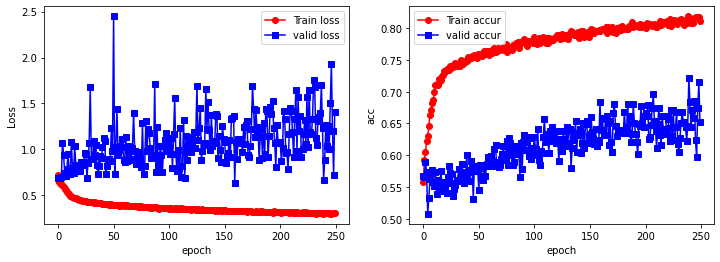

模型保存于2022-11-20_04_14_18


In [7]:
print(train_set)

# 当GPU可用时调用cuda
device = "cuda" if torch.cuda.is_available() else "cpu"

# 初始化模型并放在指定的设备上运行
model = Residual_Network().to(device)
model.device = device

# 对分类任务采用交叉熵损失
criterion = nn.CrossEntropyLoss()

# 初始化优化器（此处为Adam优化器，应用了自适应的学习率）
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loss_epoch = []
train_acc_epoch = []
valid_loss_epoch = []
valid_acc_epoch = []

enter_ = 1
enter_2 = 1

best_acc = 0
stale = 0

for epoch in range(n_epochs):
    # ---------- Training ----------
    
    '''
    确保模型在训练集上处于训练模式
    '''
    model.train()
    

    '''
    记录训练结果
    '''
    train_loss = []
    train_accs = []

    '''
    迭代训练
    
    '''
    for batch in tqdm(train_loader):
        # 一个batch包含了图片和标签信息
        imgs, origin, labels = batch

        # 向前迭代
        logits = model(imgs.to(device), origin.to(device))
        
        
        # 计算交叉熵损失
        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()

        # 计算梯度
        loss.backward()

        # 防止梯度爆炸
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # 更新参数
        optimizer.step()

        # 计算当前批的准确率
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # 记录损失和准确率
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_loss_epoch.append(train_loss)
    train_acc_epoch.append(train_acc)


    # 打印信息
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- 验证 ----------
    # 确保模型处于测试模式
    model.eval()

    # 用于记录信息
    valid_loss = []
    valid_accs = []

    # 迭代
    for batch in tqdm(valid_loader):
        imgs, origin, labels = batch

        # 迭代时不需要计算梯度
        with torch.no_grad():
            logits = model(imgs.to(device), origin.to(device))

        loss = criterion(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    valid_loss_epoch.append(valid_loss)
    valid_acc_epoch.append(valid_acc)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    _exp_name = "Residual_Network"
    # 更新日志
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt", "a"):
            print(
                f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt", "a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # 保存模型
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(),
                   f"{_exp_name}_best.ckpt")
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvement {patience} consecutive epochs, early stopping")
            break

'''
绘制训练损失和准确率曲线
'''
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_loss_epoch,
         "ro-", label="Train loss")
plt.plot(range(n_epochs), valid_loss_epoch,
         "bs-", label="valid loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_acc_epoch,
         "ro-", label="Train accur")
plt.plot(range(n_epochs), valid_acc_epoch,
         "bs-", label="valid accur")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

time_finish = time.strftime('%Y-%m-%d_%H_%M_%S', time.localtime())
print("模型保存于" + time_finish)